In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import spacy
import pickle
import itertools
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('cleaned_reviews_dataframe')

In [3]:
df.head()

,reviews,sentiment,cleaned_reviews
0,Working with one of the best Shakespeare sourc...,0,work with one of the good shakespeare source t...
1,"Well...tremors I, the original started off in ...",0,well tremor i the original start off in and i ...
2,Ouch! This one was a bit painful to sit throug...,0,ouch this one be a bit painful to sit through ...
3,"I've seen some crappy movies in my life, but t...",0,-PRON- have see some crappy movie in -PRON- li...
4,"""Carriers"" follows the exploits of two guys an...",0,carrier follow the exploit of two guy and tw...


### StopWords

In [4]:
# create stopwords and update as spacy lemmatizer converts all pronouns (i, we, us, etc..) to -PRON-
stopwords_list = stopwords.words('english')+['pron', '-PRON-']
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Modeling

### Functions for modeling

In [5]:
#function to train test split our cleaned reviews and vectorize using specific stopwords
def split_vectorize(predictor, target, vectorizer, stopwords):
    #TRAIN/TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(predictor, target, random_state=333)
    
    # vectorize our predictor column, n_gram range was chosen as we found having groups of words
    # increased our score, min_df of 7 got rid of many nonsensical tokens such as 'zzzhf' and kept
    # dataframe at a manageable size (around 50,000 columns)
    vect = vectorizer(ngram_range=(1, 3), min_df = 7, stop_words=stopwords)
    
    #fit/transform train set and transform tet set
    X_train=vect.fit_transform(X_train)
    X_test=vect.transform(X_test)
    
    # make into a dataframe with the ngrams as column names
    X_train = pd.DataFrame(X_train.toarray(), columns=vect.get_feature_names())
    X_test = pd.DataFrame(X_test.toarray(), columns=vect.get_feature_names())
    
    #return the 
    return X_train, X_test, y_train, y_test, vectorizer    

In [6]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Bag Of Words

In [7]:
#train test split and vectorize our cleaned reviews using CountVectorizer
X_train, X_test, y_train, y_test, BOW_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], CountVectorizer, stopwords_list)

In [8]:
#pickle our BOW vectorizer for use with holdout set
pickle_out = open("BOW_vect.pickle","wb")
pickle.dump(BOW_vect, pickle_out)
pickle_out.close()

### Logistic Regression

In [9]:
#INSTANTIATE LOGISTIC REGRESSION
logreg = LogisticRegression(C = .01, random_state = 333)


#fit to training set
logreg.fit(X_train, y_train)

#predict on train and test set
y_pred_log_train = logreg.predict(X_train)
y_pred_log_test = logreg.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_log_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_log_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_log_train, y_train))
print('Test F1 score: ', f1_score(y_pred_log_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_log_test)/len(y_test))

Train Accuracy score:  0.9285866666666667
Test Accuracy score:  0.8824

Train F1 score:  0.9293366404559608
Test F1 score:  0.884124231436229

Confusion matrix test set: 
 [[0.43376 0.06496]
 [0.05264 0.44864]]


Confusion Matrix, without normalization
[[2711  406]
 [ 329 2804]]


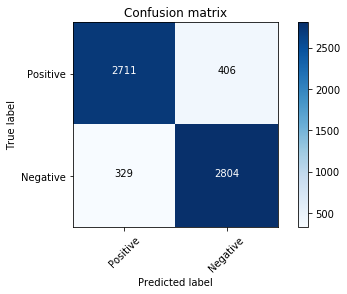

In [10]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_log_test)
classes = ['Positive', 'Negative']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [11]:
#get coefficient values for features and create dict with feature and importance
dictionary_logreg = dict(zip(list(X_train.columns), list(logreg.coef_[0])))

#sort dictionary by most important features
dictionary_logreg = {k: v for k, v in sorted(dictionary_logreg.items(), key=lambda item: abs(item[1]))}

# make dictionary a list with most important features at top
importance = dictionary_logreg.items()
impt_features = list(importance)[::-1]

In [12]:
# Top ten most important features for logistic regression model
impt_features[:10]

[('waste', -0.6369390978180243),
 ('bad', -0.5942151784481359),
 ('excellent', 0.5282746064058913),
 ('awful', -0.5083091328531034),
 ('boring', -0.44226076377710194),
 ('great', 0.41382745120610454),
 ('poor', -0.41025905355035314),
 ('favorite', 0.40398783345962336),
 ('perfect', 0.3859690539725842),
 ('amazing', 0.36910496961797357)]

In [13]:
# (spoiler) pickling our best model with BOW vectorization
pickle_out = open("log_reg_mod.pickle","wb")
pickle.dump(logreg, pickle_out)
pickle_out.close()

### Naive Bayes

In [14]:
#INSTANTIATE NB Classifier
Naive = MultinomialNB(alpha=.1, fit_prior= True)

#fit to training set
Naive.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive.predict(X_train)
y_pred_nb_test = Naive.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test)/len(y_test))

Train Accuracy score:  0.92544
Test Accuracy score:  0.87376

Train F1 score:  0.9254479522184301
Test F1 score:  0.8743030109925124

Confusion matrix test set: 
 [[0.43472 0.064  ]
 [0.06224 0.43904]]


### Decision Tree

In [ ]:
# INSATNTIATE DECISION TREE MODEL
tree = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

#fit to training set
tree.fit(X_train, y_train)

#predict on train and test set
y_pred_tree_train = tree.predict(X_train)
y_pred_tree_test = tree.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_tree_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_tree_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_tree_train, y_train))
print('Test F1 score: ', f1_score(y_pred_tree_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_tree_test)/len(y_test))

### Random Forest

In [ ]:
#INSTANTIATE RANDOM FOREST MODEL
rfc = RandomForestClassifier(random_state = 333, class_weight='balanced')

#fit to training set
rfc.fit(X_train, y_train)

#predict on train and test set
y_pred_rfc_train = rfc.predict(X_train)
y_pred_rfc_test = rfc.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_rfc_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_rfc_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_rfc_train, y_train))
print('Test F1 score: ', f1_score(y_pred_rfc_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_rfc_test)/len(y_test))

## BOW GridSearch

We are looking to prioritze accuracy score in our model but want to take into account F1 if there is a negligible difference in accuracy. We will pick our two best performing models to try and improve upon, those being Logistic Regression and Naive Bayes. In the following steps we will tune our parameters and see if we can get improve our models

### Logistic Grid

In [ ]:
#SET PARAMATER GRID
param_grid_log =  {'C': np.logspace(-4, 4, 20),
                  'fit_intercept': [True, False],
                  'max_iter': [1000,10_000]}
grid_search_log = GridSearchCV(estimator = logreg, param_grid = param_grid_log ,cv = 7,scoring = 'accuracy')

In [ ]:
grid_search_log.fit(X_train,y_train)
log_params = grid_search_log.best_params_
print(log_params)

In [ ]:
logreg_grid = LogisticRegression(**log_params, class_weight='balanced', random_state = 333)

logreg_grid.fit(X_train, y_train)

y_pred_log_grid = logreg_grid.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_log_grid))

# checking F1
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_log_grid))

### Naive Bayes Grid

In [ ]:
#SET PARAMATER GRID
param_grid_nb =   {'alpha': [1,0.5],
                   'fit_prior': [True, False]}
grid_search_nb = GridSearchCV(estimator = Naive, param_grid = param_grid_nb,cv = 7,scoring = 'accuracy')

In [ ]:
grid_search_nb.fit(X_train,y_train)
nb_params = grid_search_nb.best_params_
print(nb_params)

In [ ]:
nb_grid = MultinomialNB(**nb_params, class_weight='balanced', random_state = 333)

nb_grid.fit(X_train, y_train)

y_pred_nb_grid = nb_grid.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_nb_grid))

# checking F1
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_nb_grid))

### Best BOW model with updated stopwords

In [ ]:
# adding in most common words from Unigram analysis
stopwords_new = stopwords_list + ['movie', 'film']

In [ ]:
#train test split and vectorize our cleaned reviews using CountVectorizer and updated stopwords
X_train, X_test, y_train, y_test, BOW_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], CountVectorizer, stopwords_new)

In [ ]:
#INSTANTIATE LOGISTIC REGRESSION
logreg = LogisticRegression(C = .01, random_state = 333)
# can choose a regularization C = ? to penalize so it doesnt overfit

#fit to training set
logreg.fit(X_train, y_train)

#predict on train and test set
y_pred_log_train = logreg.predict(X_train)
y_pred_log_test = logreg.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_log_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_log_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_log_train, y_train))
print('Test F1 score: ', f1_score(y_pred_log_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_log_test)/len(y_test))

## TFIDF

In [ ]:
#train test split and vecotrize our cleaned reviews using CountVectorizer
X_train, X_test, y_train, y_test, TFIDF_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], TfidfVectorizer, stopwords_list)

In [ ]:
pickle_out = open("TFIDF_vect.pickle","wb")
pickle.dump(TFIDF_vect, pickle_out)
pickle_out.close()

### Logistic Regression

In [ ]:
#INSTANTIATE LOGISTIC REGRESSION
logreg = LogisticRegression(C = .01, random_state = 333)
# can choose a regularization C = ? to penalize so it doesnt overfit

#fit to training set
logreg.fit(X_train, y_train)

#predict on train and test set
y_pred_log_train = logreg.predict(X_train)
y_pred_log_test = logreg.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_log_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_log_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_log_train, y_train))
print('Test F1 score: ', f1_score(y_pred_log_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_log_test)/len(y_test))

### Naive Bayes

In [ ]:
#INSTANTIATE NB Classifier
Naive = MultinomialNB(alpha=0.1, fit_prior= True)

#fit to training set
Naive.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive.predict(X_train)
y_pred_nb_test = Naive.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test)/len(y_test))

In [ ]:
pickle_out = open("nb_mod.pickle","wb")
pickle.dump(Naive, pickle_out)
pickle_out.close()

### Decision Tree

In [ ]:
# INSATNTIATE DECISION TREE MODEL
tree = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

#fit to training set
tree.fit(X_train, y_train)

#predict on train and test set
y_pred_tree_train = tree.predict(X_train)
y_pred_tree_test = tree.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_tree_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_tree_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_tree_train, y_train))
print('Test F1 score: ', f1_score(y_pred_tree_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_tree_test)/len(y_test))

### Random Forest

In [ ]:
#INSTANTIATE RANDOM FOREST MODEL
rfc = RandomForestClassifier(random_state = 333, class_weight='balanced')

#fit to training set
rfc.fit(X_train, y_train)

#predict on train and test set
y_pred_rfc_train = rfc.predict(X_train)
y_pred_rfc_test = rfc.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_rfc_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_rfc_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_rfc_train, y_train))
print('Test F1 score: ', f1_score(y_pred_rfc_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_rfc_test)/len(y_test))

## GridSearch

### Logistic Grid

In [ ]:
#SET PARAMATER GRID
param_grid_log =  {'C': np.logspace(-4, 4, 20),
                  'fit_intercept': [True, False],
                  'max_iter': [1000,10_000]}
grid_search_log = GridSearchCV(estimator = logreg, param_grid = param_grid_log ,cv = 7,scoring = 'accuracy')

In [ ]:
#train test split and vectorize our cleaned reviews using updated stopwords
X_train, X_test, y_train, y_test, TFIDF_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], TfidfVectorizer, stopwords_list)

In [ ]:
grid_search_log.fit(X_train,y_train)
log_params = grid_search_log.best_params_
print(log_params)

In [ ]:
logreg_grid = LogisticRegression(**log_params, class_weight='balanced', random_state = 333)

logreg_grid.fit(X_train, y_train)

y_pred_log_grid = logreg_grid.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_log_grid))

# checking F1
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_log_grid))

### Naive Bayes Grid

In [ ]:
#SET PARAMATER GRID
param_grid_nb =   {'alpha': [1,0.5],
                   'fit_prior': [True, False]}
grid_search_nb = GridSearchCV(estimator = Naive, param_grid = param_grid_nb,cv = 7,scoring = 'accuracy')

In [ ]:
#train test split and vectorize our cleaned reviews using updated stopwords
X_train, X_test, y_train, y_test, TFIDF_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], TfidfVectorizer, stopwords_list)

In [ ]:
grid_search_nb.fit(X_train,y_train)
nb_params = grid_search_nb.best_params_
print(nb_params)

In [ ]:
nb_grid = MultinomialNB(**nb_params, class_weight='balanced', random_state = 333)

nb_grid.fit(X_train, y_train)

y_pred_nb_grid = nb_grid.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_nb_grid))

# checking F1
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_nb_grid))

## Best TFIDF Model with updated stopwords

In [ ]:
#train test split and vectorize our cleaned reviews using updated stopwords
X_train, X_test, y_train, y_test, TFIDF_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], TfidfVectorizer, stopwords_new)

In [ ]:
#INSTANTIATE NB Classifier
Naive = MultinomialNB(alpha=0.1, fit_prior= True)

#fit to training set
Naive.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive.predict(X_train)
y_pred_nb_test = Naive.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test)/len(y_test))